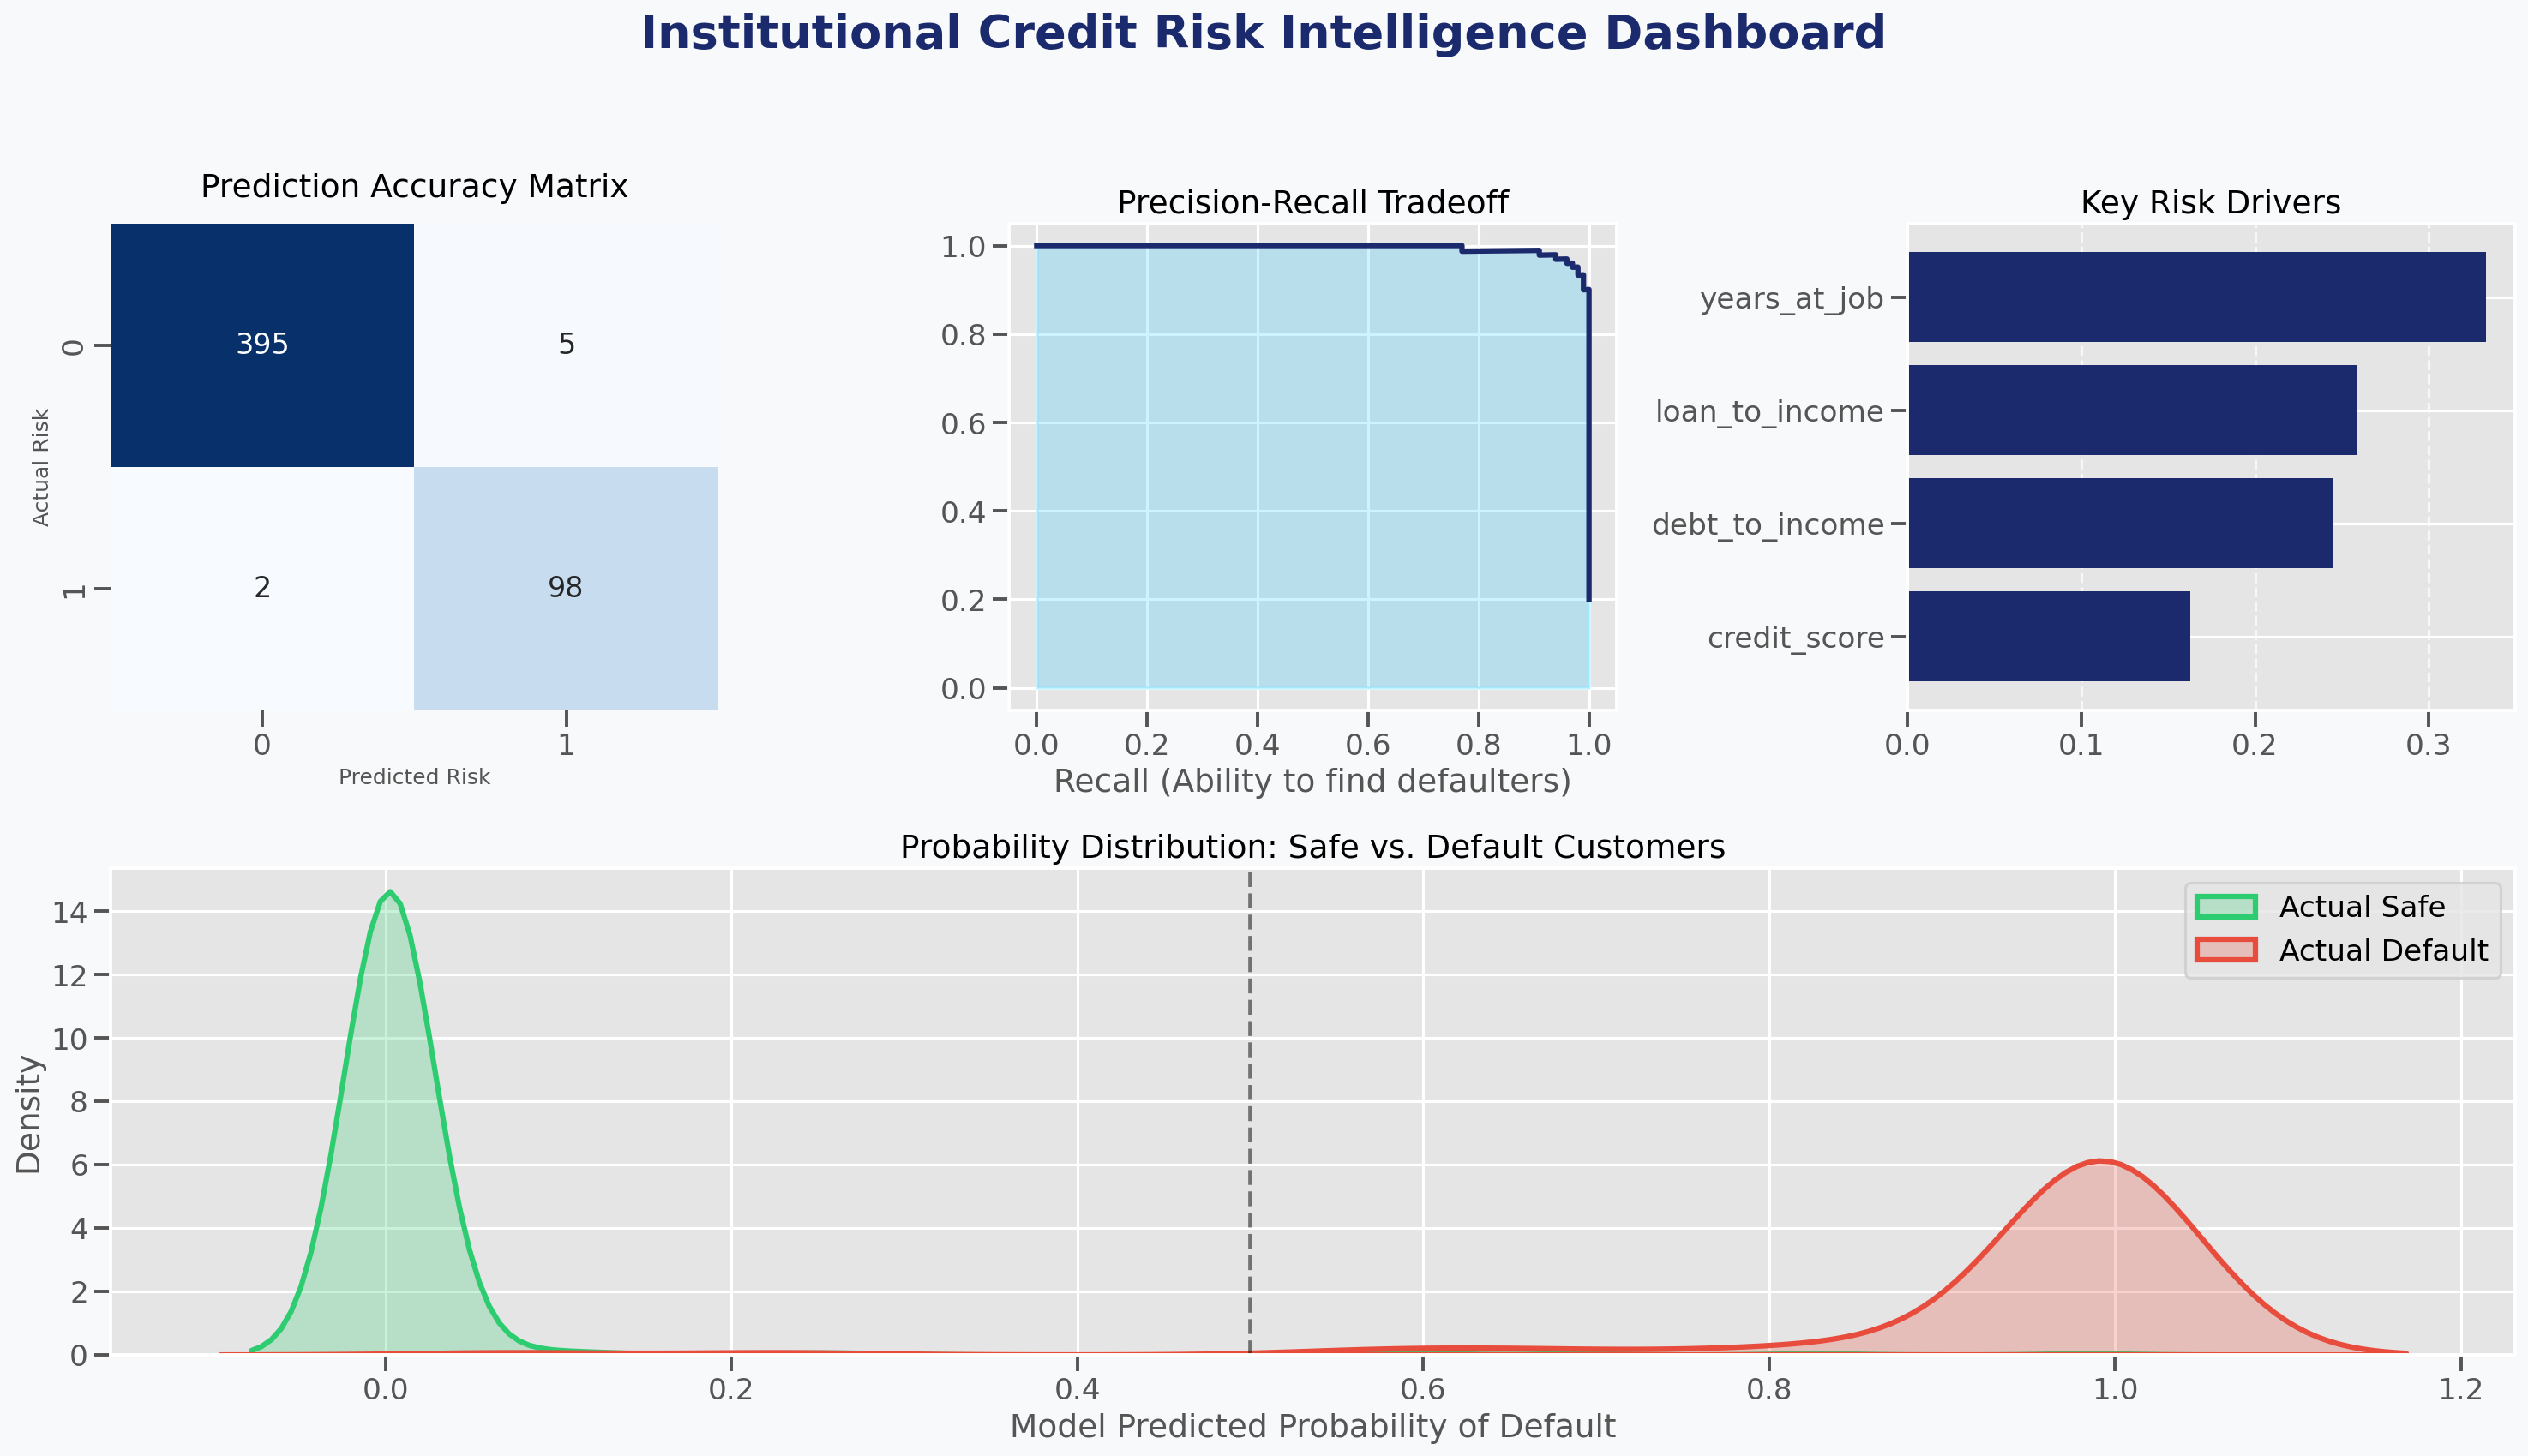

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.95      0.98      0.97       100

    accuracy                           0.99       500
   macro avg       0.97      0.98      0.98       500
weighted avg       0.99      0.99      0.99       500



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, auc)
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier

# --- 1. SETTINGS & BEAUTIFICATION ---
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
sns.set_context("talk")
# Custom Fintech Color Palette
colors = ["#1a2a6c", "#b21f1f", "#fdbb2d", "#00c6ff"]

# --- 2. GENERATING BALANCED REALISTIC DATA ---
def generate_balanced_data(n_samples=2000):
    np.random.seed(42)
    # We force a 20% default rate so the model can actually learn
    n_default = int(n_samples * 0.2)
    n_safe = n_samples - n_default

    def create_group(n, is_default):
        score_mu = 550 if is_default else 710
        dti_mu = 0.45 if is_default else 0.25
        return pd.DataFrame({
            'credit_score': np.random.normal(score_mu, 80, n).clip(300, 850),
            'debt_to_income': np.random.normal(dti_mu, 0.1, n).clip(0.05, 0.8),
            'loan_to_income': np.random.normal(0.4 if is_default else 0.2, 0.1, n).clip(0, 1),
            'years_at_job': np.random.poisson(3 if is_default else 8, n).clip(0, 40),
            'is_default': 1 if is_default else 0
        })

    df = pd.concat([create_group(n_safe, False), create_group(n_default, True)])
    return df.sample(frac=1).reset_index(drop=True)

df = generate_balanced_data()
X = df.drop('is_default', axis=1)
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# --- 3. MODEL WITH GRADIENT BOOSTING ---
model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8)
model.fit(X_train, y_train)

# --- 4. THE VISUAL DASHBOARD ---
def create_fintech_dashboard(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    fig = plt.figure(figsize=(20, 12), facecolor='#f8f9fa')
    gs = fig.add_gridspec(2, 3)
    fig.suptitle('Institutional Credit Risk Intelligence Dashboard', fontsize=26, fontweight='bold', color='#1a2a6c')

    # A. Confusion Matrix (Clean & Modern)
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1, annot_kws={"size": 16})
    ax1.set_title('Prediction Accuracy Matrix', fontsize=18, pad=15)
    ax1.set_xlabel('Predicted Risk', fontsize=12)
    ax1.set_ylabel('Actual Risk', fontsize=12)

    # B. Precision-Recall Curve (The "Gold Standard" for Banking)
    ax2 = fig.add_subplot(gs[0, 1])
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    ax2.fill_between(recall, precision, alpha=0.2, color='#00c6ff')
    ax2.plot(recall, precision, color='#1a2a6c', lw=3)
    ax2.set_title('Precision-Recall Tradeoff', fontsize=18)
    ax2.set_xlabel('Recall (Ability to find defaulters)')

    # C. Feature Importance (Horizontal & Sorted)
    ax3 = fig.add_subplot(gs[0, 2])
    feats = pd.Series(model.feature_importances_, index=X.columns).sort_values()
    feats.plot(kind='barh', color=colors[0], ax=ax3, width=0.8)
    ax3.set_title('Key Risk Drivers', fontsize=18)
    ax3.grid(axis='x', linestyle='--', alpha=0.7)

    # D. Distribution of Risk Scores (Crucial for Business Logic)
    ax4 = fig.add_subplot(gs[1, :])
    sns.kdeplot(y_probs[y_test==0], fill=True, label='Actual Safe', color='#2ecc71', ax=ax4, lw=3)
    sns.kdeplot(y_probs[y_test==1], fill=True, label='Actual Default', color='#e74c3c', ax=ax4, lw=3)
    ax4.axvline(0.5, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Probability Distribution: Safe vs. Default Customers', fontsize=18)
    ax4.set_xlabel('Model Predicted Probability of Default')
    ax4.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

create_fintech_dashboard(model, X_test, y_test)
print(classification_report(y_test, model.predict(X_test)))